## Glioblastoma 3D MRI with EfficientNet

Acknowledgements:

- https://www.kaggle.com/fepegar/preprocessing-mri-with-torchio
- https://github.com/shijianjian/EfficientNet-PyTorch-3D
    

U.Baid, et al., “The RSNA-ASNR-MICCAI BraTS 2021 Benchmark on Brain Tumor Segmentation and Radiogenomic Classification”, arXiv:2107.02314, 2021.

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import sys 
import json
import glob
import random
import collections
import time
import re

import numpy as np
import pandas as pd
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils import data as torch_data
from sklearn import model_selection as sk_model_selection
from torch.nn import functional as torch_functional
import torch.nn.functional as F

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Import EffNet:

In [3]:
!pip install git+https://github.com/shijianjian/EfficientNet-PyTorch-3D

  Cloning https://github.com/shijianjian/EfficientNet-PyTorch-3D to /tmp/pip-req-build-ifujzhc7
  Running command git clone -q https://github.com/shijianjian/EfficientNet-PyTorch-3D /tmp/pip-req-build-ifujzhc7
  Resolved https://github.com/shijianjian/EfficientNet-PyTorch-3D to commit 3e79bcd06216b2e831bf3300fff9636cce2cd0d1
  Created wheel for efficientnet-pytorch-3d: filename=efficientnet_pytorch_3d-0.6.3-py3-none-any.whl size=16770 sha256=babd4dc2b9985484a51b1d1c72794c95a8ad722f34917fb87e198eb6feda24ca
  Stored in directory: /tmp/pip-ephem-wheel-cache-35bb3ypb/wheels/ea/44/3d/89ce0e32ed262cff6c10d0586dc8f82bbb8ba1eeb47863abe5
Successfully built efficientnet-pytorch-3d


In [4]:
from efficientnet_pytorch_3d import EfficientNet3D

Load MRI scans into notebook:

In [5]:
!pip install torchio

     |████████████████████████████████| 156 kB 924 kB/s eta 0:00:01


In [6]:
from pathlib import Path

In [7]:
import torchio as tio

In [8]:
plt.rcParams["figure.figsize"] = (12, 10)
root_dir = '/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification'
data = tio.datasets.RSNAMICCAI(root_dir)

In [9]:
len(data)

582

In [10]:
data[0]

ImageSeriesReader (0x564388a56ab0): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000398747



Subject(Keys: ('BraTS21ID', 'MGMT_value', 'T1w', 'T1wCE', 'T2w', 'FLAIR'); images: 4)

ImageSeriesReader (0x564388a56ab0): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000398747



ScalarImage(shape: (1, 512, 512, 400); spacing: (0.50, 0.50, 0.60); orientation: LIP+; dtype: torch.ShortTensor; memory: 200.0 MiB)


ImageSeriesReader (0x564388a56ab0): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000398747



1


ImageSeriesReader (0x564388a56ab0): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000398747



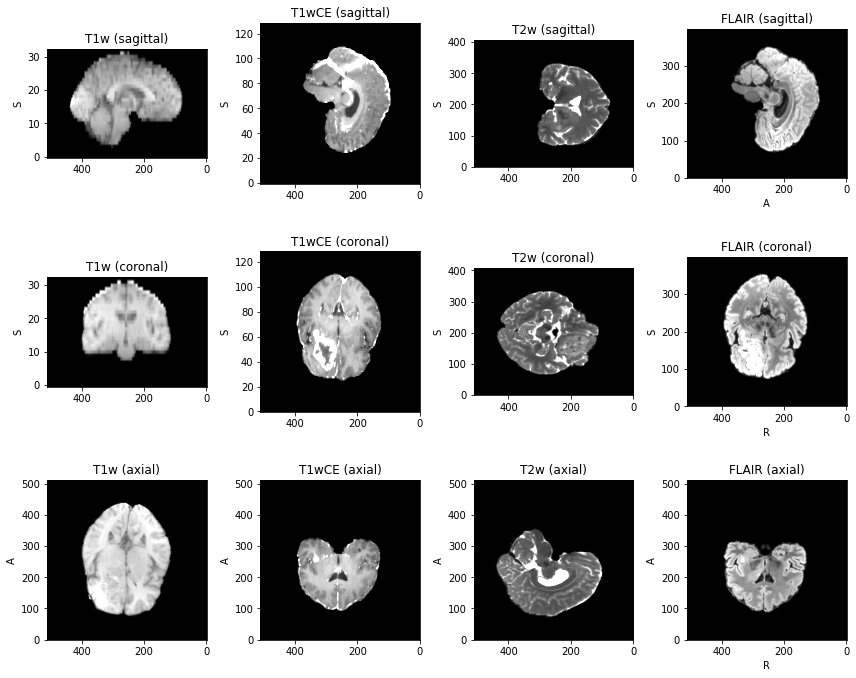

In [11]:
print(data[0].FLAIR)
print(data[0].MGMT_value)
data[0].plot(reorient=False)

In [12]:
preprocessing_transforms = (
    tio.ToCanonical(),
    tio.Resample(1, image_interpolation='bspline'),
    tio.Resample('T1w', image_interpolation='nearest'),
)
preprocess = tio.Compose(preprocessing_transforms)
train_set = tio.datasets.RSNAMICCAI(root_dir, train=True, transform=preprocess)
test_set = tio.datasets.RSNAMICCAI(root_dir, train=False, transform=preprocess)

In [13]:
def preprocess_dataset(dataset, out_dir, parallel=True, demo=True):
    import shutil
    import multiprocessing as mp
    from pathlib import Path
    from tqdm.notebook import tqdm
    if demo:  # just to showcase TorchIO
        dataset._subjects = dataset._subjects[:5]
    out_dir = Path(out_dir)
    labels_name = 'train_labels.csv'
    out_dir.mkdir(exist_ok=True, parents=True)
    shutil.copy(dataset.root_dir / labels_name, out_dir / labels_name)
    subjects_dir = out_dir / ('train' if dataset.train else 'test')
    if parallel:
        loader = torch.utils.data.DataLoader(
            dataset,
            num_workers=mp.cpu_count(),
            collate_fn=lambda x: x[0],
        )
        iterable = loader
    else:
        iterable = dataset
    for subject in tqdm(iterable):
        subject_dir = subjects_dir / subject.BraTS21ID
        for name, image in tqdm(subject.get_images_dict().items(), leave=False):
            image_dir = subject_dir / name
            image_dir.mkdir(exist_ok=True, parents=True)
            image_path = image_dir / f'{name}.nii.gz'
            image.save(image_path)

In [14]:
out_dir = 'rsna-preprocessed'
if not Path(out_dir).is_dir():
    preprocess_dataset(train_set, out_dir)
    preprocess_dataset(test_set, out_dir)

  0%|          | 0/5 [00:00<?, ?it/s]

ImageSeriesReader (0x564394541660): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000398747

ImageSeriesReader (0x564394541660): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000697556



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

ImageSeriesReader (0x564394541660): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000754849

ImageSeriesReader (0x564394541660): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000942467



  0%|          | 0/4 [00:00<?, ?it/s]

ImageSeriesReader (0x564394541660): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000899893



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

ImageSeriesReader (0x564394541660): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000981787

ImageSeriesReader (0x564394541660): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000863878



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

ImageSeriesReader (0x564394541660): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.0010352

ImageSeriesReader (0x564394541660): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000631195



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

ImageSeriesReader (0x564394541660): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.0004

ImageSeriesReader (0x564394541660): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000997044



  0%|          | 0/4 [00:00<?, ?it/s]

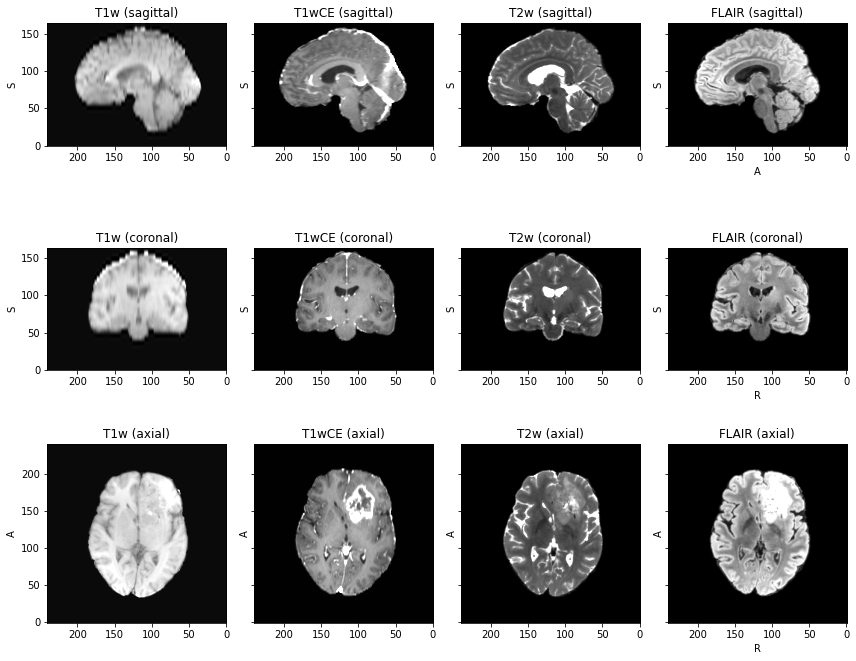

In [15]:
new_train_set = tio.datasets.RSNAMICCAI(out_dir, train=True)
new_test_set = tio.datasets.RSNAMICCAI(out_dir, train=False)
subject = new_train_set[0]
subject.plot(reorient=False)

In [16]:
def preprocess_dataset(dataset, out_dir, parallel=True, demo=True):
    import shutil
    import multiprocessing as mp
    from pathlib import Path
    from tqdm.notebook import tqdm
    if demo:  # just to showcase TorchIO
        dataset._subjects = dataset._subjects[:5]
    out_dir = Path(out_dir)
    labels_name = 'train_labels.csv'
    out_dir.mkdir(exist_ok=True, parents=True)
    shutil.copy(dataset.root_dir / labels_name, out_dir / labels_name)
    subjects_dir = out_dir / ('train' if dataset.train else 'test')
    if parallel:
        loader = torch.utils.data.DataLoader(
            dataset,
            num_workers=mp.cpu_count(),
            collate_fn=lambda x: x[0],
        )
        iterable = loader
    else:
        iterable = dataset
    for subject in tqdm(iterable):
        subject_dir = subjects_dir / subject.BraTS21ID
        for name, image in tqdm(subject.get_images_dict().items(), leave=False):
            image_dir = subject_dir / name
            image_dir.mkdir(exist_ok=True, parents=True)
            image_path = image_dir / f'{name}.nii.gz'
            image.save(image_path)

In [17]:
out_dir = 'rsna-preprocessed'
if not Path(out_dir).is_dir():
    preprocess_dataset(train_set, out_dir)
    preprocess_dataset(test_set, out_dir)

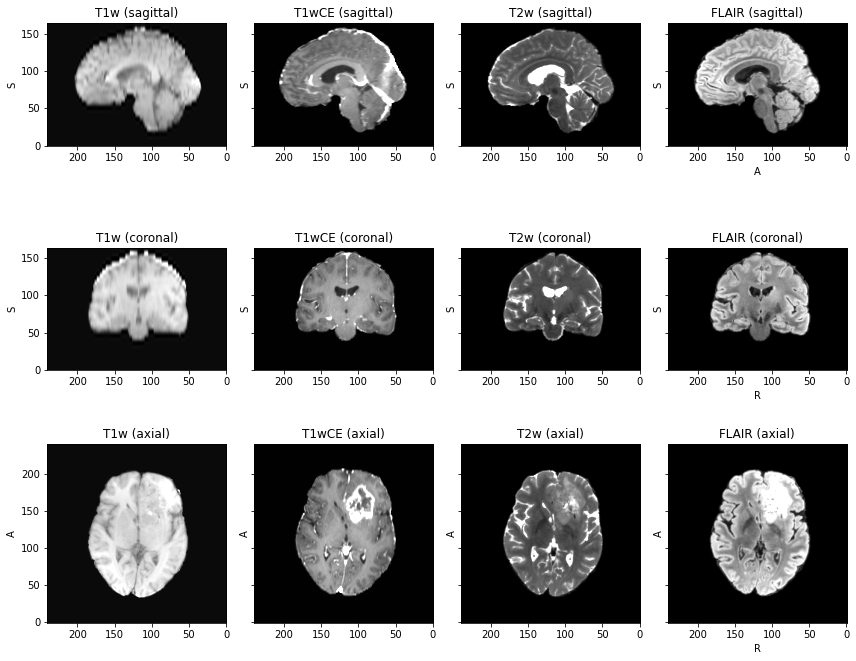

In [18]:
new_train_set = tio.datasets.RSNAMICCAI(out_dir, train=True)
new_test_set = tio.datasets.RSNAMICCAI(out_dir, train=False)
subject = new_train_set[0]
subject.plot(reorient=False)